Initialize the enviroment and import the packages

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Read CSV data file

In [2]:
#data <- read_csv("data/heart_attack.csv")
url = "https://raw.githubusercontent.com/l-glucose/dsci100/main/data/heart_attack.csv"
data <- read_csv(url)
data
sum(is.na(data))

Rows: 1319 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): class
dbl (8): age, gender, impluse, pressurehight, pressurelow, glucose, kcm, tro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
64,1,66,160,83,160,1.80,0.012,negative
21,1,94,98,46,296,6.75,1.060,positive
55,1,64,160,77,270,1.99,0.003,negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive
54,1,58,117,68,443,5.80,0.359,positive
51,1,94,157,79,134,50.89,1.770,positive


[1] 0

In [13]:
data <- data |>
    mutate(class = as_factor(class))
data <- data |>
    filter(impluse <= 200)
data <- data |>
    mutate(pressure_diff = pressurehight - pressurelow)

data_tidy <- data |>
  rename(
    pressure_high = pressurehight,
    pressure_low = pressurelow
  )
data_split <- initial_split(data_tidy, prop = 0.75, strata = class) 
data_training <- training(data_split)
data_testing <- testing(data_split)



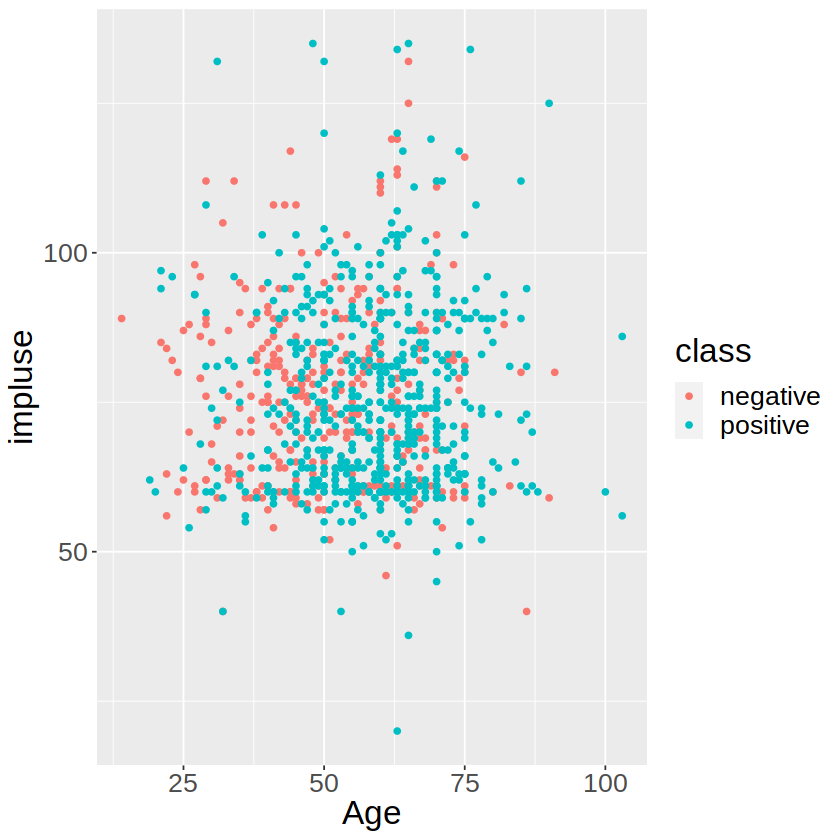

In [14]:
plot <- data_training |> ggplot(aes(x = age, y = impluse, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("impluse") +
    theme(text = element_text(size=20))
plot

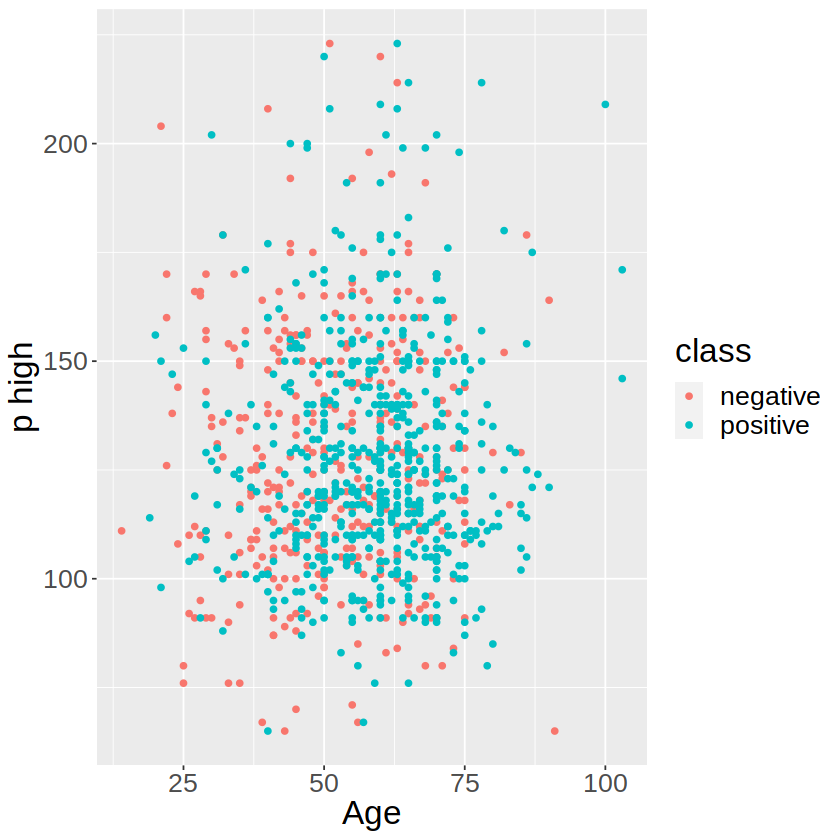

In [16]:
# sample_50 <- sample_n(data, 50)
plot_diff <- data_training |> ggplot(aes(x = age, y = pressure_high, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("p high") +
    theme(text = element_text(size=20))
plot_diff

In [17]:
data_age <- data_training |>
    group_by(age, class) |>
    summarize(kcm = mean(kcm, na.rm = TRUE))
data_age

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,class,kcm
<dbl>,<fct>,<dbl>
14,negative,2.62
19,positive,300.00
20,positive,5.22
⋮,⋮,⋮
91,negative,5.37
100,positive,5.66
103,positive,60.64


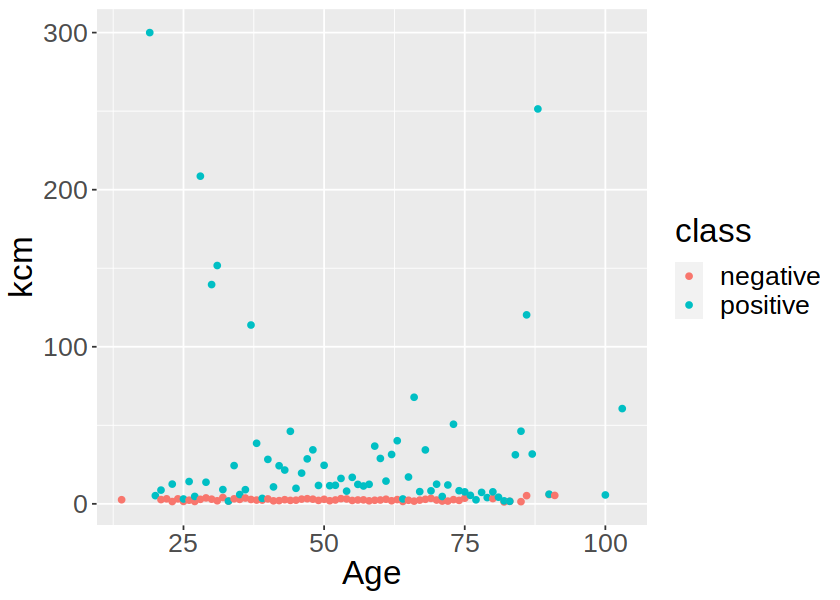

In [22]:
options(repr.plot.width = 7, repr.plot.height = 5) 
average_plot <- data_age |> ggplot(aes(x = age, y = kcm, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("kcm") +
    theme(text = element_text(size=20))
average_plot

`summarise()` has grouped output by 'kcm'. You can override using the `.groups`
argument.


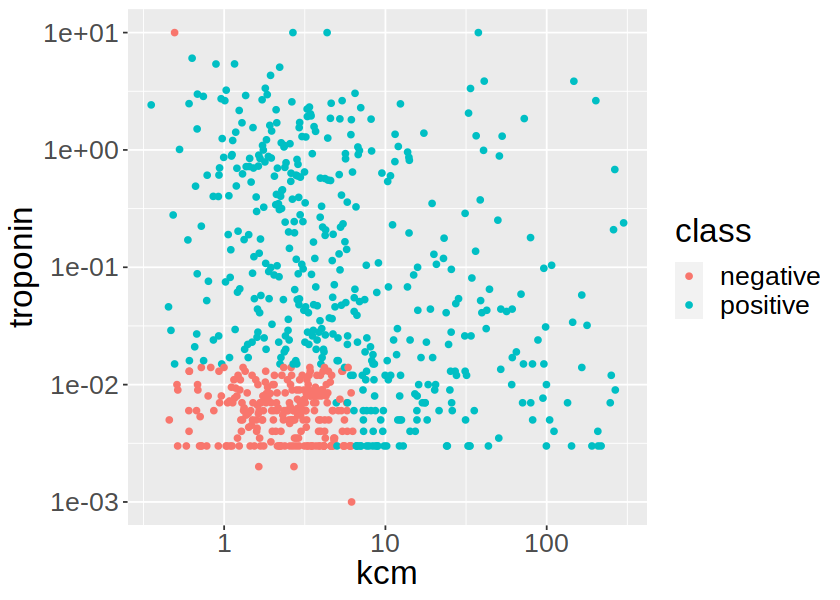

In [23]:
data_kcm <- data_training |>
    group_by(kcm, class) |>
    summarize(troponin = mean(troponin, na.rm = TRUE))

plot2 <- data_kcm |> ggplot(aes(x = kcm, y = troponin, color = class)) + 
    geom_point() +
    xlab("kcm") + 
    ylab("troponin") +
    scale_x_continuous(trans = 'log10') + 
    scale_y_continuous(trans = 'log10') + 
    theme(text = element_text(size=20))
plot2

In [24]:
create_age_group <- function(age) {
  if (age <= 20) {
    return("1-20")
  } else if (age <= 25) {
    return("21-25")
  } else if (age <= 30) {
    return("26-30")
  } else if (age <= 35) {
    return("31-35")
  } else if (age <= 40) {
    return("36-40")
  } else if (age <= 45) {
    return("41-45")
  } else if (age <= 50) {
    return("46-50")
  } else if (age <= 55) {
    return("51-55")
  } else if (age <= 60) {
    return("56-60")
  } else if (age <= 65) {
    return("61-65")
  } else if (age <= 70) {
    return("66-70")
  } else if (age <= 75) {
    return("71-75")
  } else {
    return("76-90")
  }
}

summarized_data <- data_training |>
  mutate(age_group = sapply(age, create_age_group)) |>
  group_by(age_group, class) |>
  summarise(across(where(is.numeric), mean, .names = "mean_{.col}"), .groups = "drop")

summarized_data

age_group,class,mean_age,mean_gender,mean_impluse,mean_pressure_high,mean_pressure_low,mean_glucose,mean_kcm,mean_troponin,mean_pressure_diff
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-20,negative,14.00000,0.0000000,89.00000,111,57.00000,133.0000,2.620000,0.012000000,54.00000
1-20,positive,19.50000,0.5000000,61.00000,135,64.50000,171.5000,152.610000,0.922000000,70.50000
21-25,negative,23.11111,0.6666667,73.22222,134,72.22222,149.5556,2.581111,0.003888889,61.77778
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
71-75,positive,73.31250,0.5625000,76.12500,126.9792,71.12500,135.2917,15.397687,0.24870833,55.85417
76-90,negative,85.28571,0.5714286,66.85714,133.5714,72.14286,160.5714,3.432857,0.01085714,61.42857
76-90,positive,82.47727,0.4772727,78.45455,127.2045,71.25000,139.2727,29.474773,0.35302273,55.95455


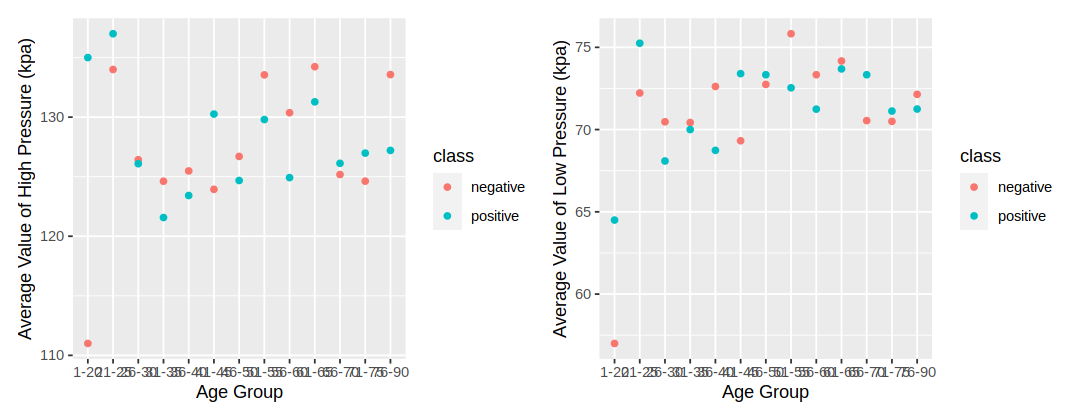

In [31]:
plot_data <- summarized_data |>
    slice()
plot_pressure_high <- summarized_data |> ggplot(aes(x = age_group, y = mean_pressure_high, color = class)) +
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Value of High Pressure (kpa)")

plot_pressure_low <- summarized_data |> ggplot(aes(x = age_group, y = mean_pressure_low, color = class)) +
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Value of Low Pressure (kpa)")
library(patchwork)
options(repr.plot.width = 9, repr.plot.height = 3.5) 
plot_pressure_high + plot_pressure_low

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


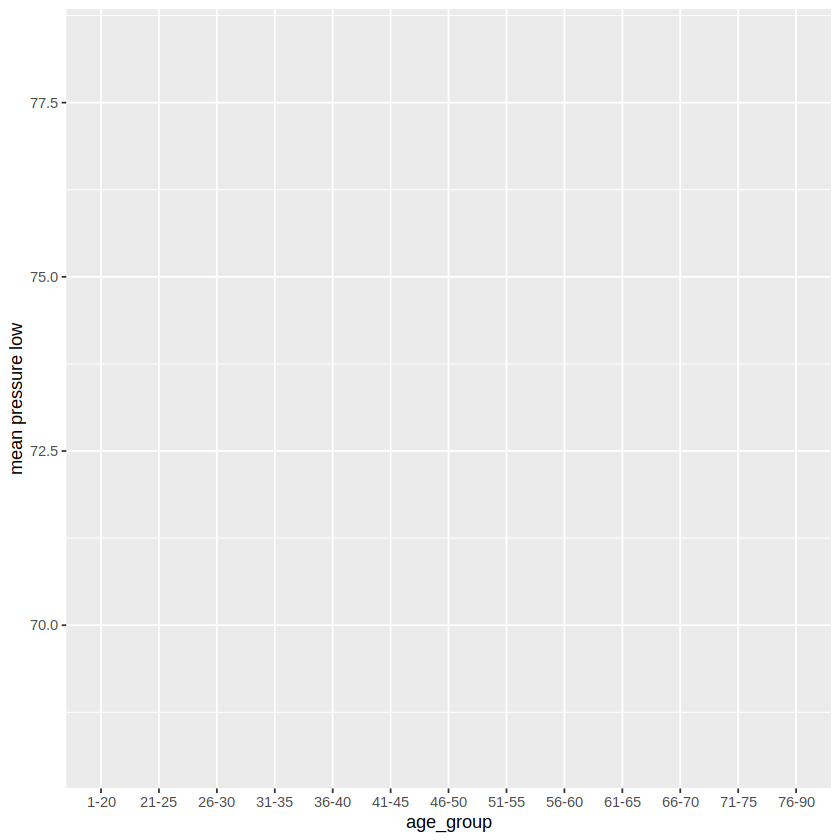

In [11]:
summarize_data_positive <- summarized_data |> 
    filter(class == "positive")


plot_age_group_line <- summarize_data_positive |> ggplot() +
    geom_line(aes(x = age_group, y = mean_pressurelow)) +
    xlab("age_group") + 
    ylab("mean pressure low")
plot_age_group_line